In [ ]:
#!pip install -r requirements.txt

In [13]:
# import necessary functions and libraries

import torch
from data.load_trajectory import generate_bloch_trajectory
from data.noisy_data import generate_data
from figures.bloch_animation import create_interactive_bloch_sphere
from train.pinn_simulation import BlochNN, train_pinn
from train.param_estimator import train_inv_pinn_1, train_inv_pinn_2


**Solve the Bloch vector equations numerically**

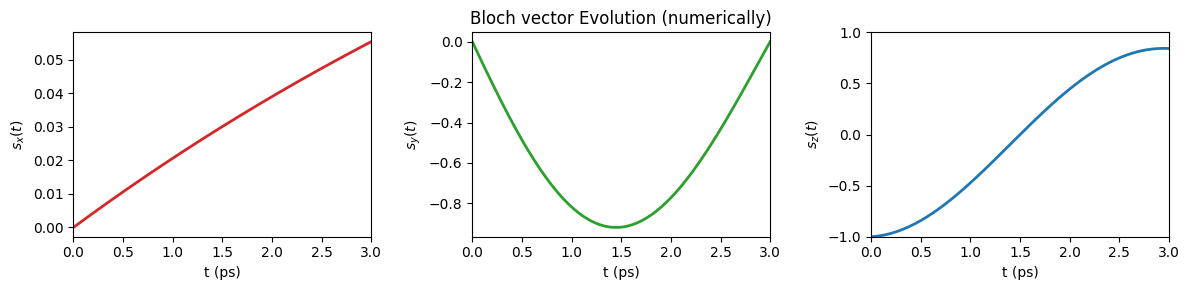

In [2]:
t, sx, sy, sz = generate_bloch_trajectory(
    A = torch.tensor(0.0112),
    v_c = torch.tensor(3.04),
    T = 10.0,
    D = 3.0,
    plot = True
)


In [15]:
fig = create_interactive_bloch_sphere(sx=sx.flatten(), sy=sy.flatten(), sz=sz.flatten(), t_eval=t.flatten())
fig.show()

**Training the neural network to learn the solutions to the Bloch vectorized Lindblad master equations**

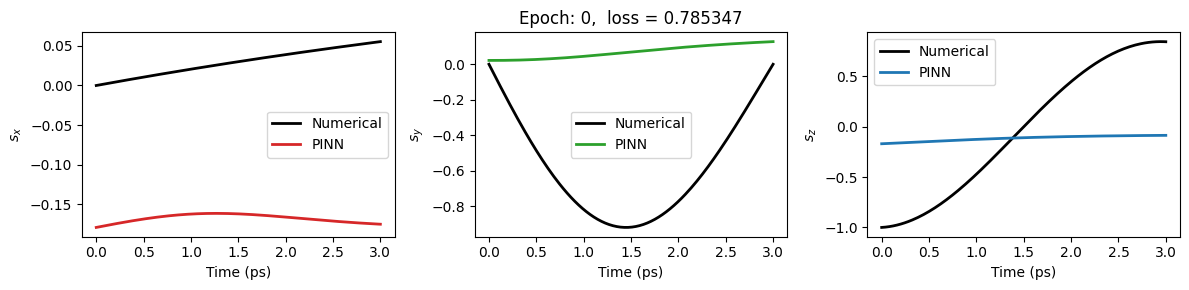

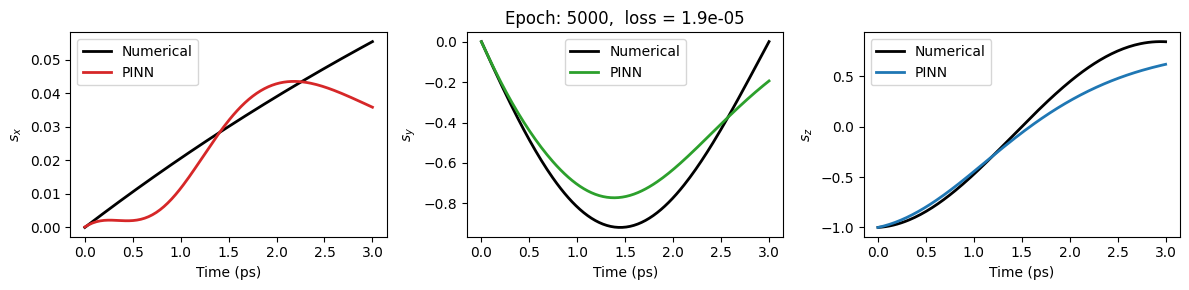

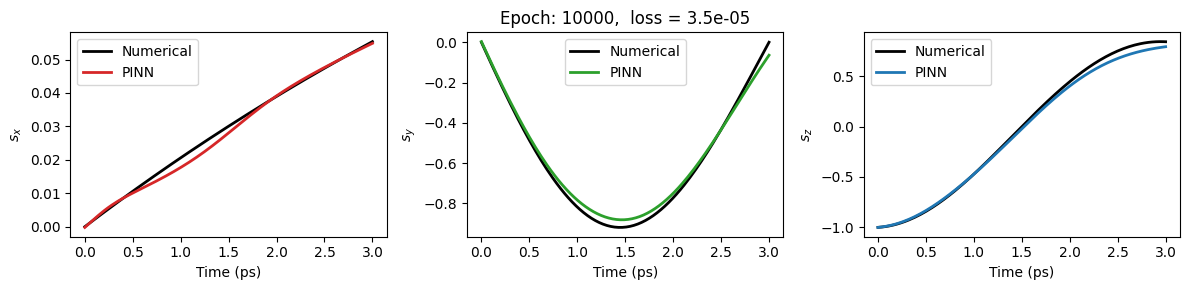

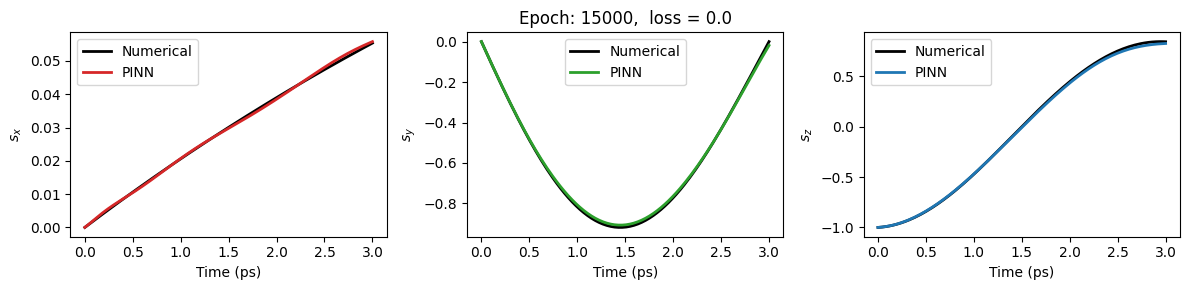

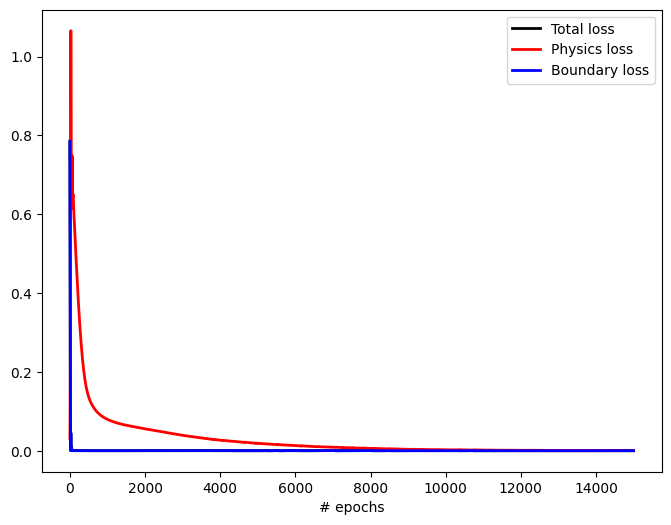

In [3]:
torch.manual_seed(2025)

# Specify the physical constants
A = torch.tensor(0.0112)                  # ps/K
v_c = torch.tensor(3.04)                  # 1/ps
T = torch.tensor(10.0)                    # K
D = torch.tensor(3.0)                     # ps


# Create PINN
pinn = BlochNN(n_input=1, n_output=3, n_hidden=32, n_layers=4)

# Prepare training/test inputs
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, D, 150).view(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, D, 150).view(-1, 1)

# Train
model1 = train_pinn(pinn, t_physics, t_boundary, t_test,
           A, v_c, T, D, sx, sy, sz,
           lambda1=1e-3, epochs=15001, lr=1e-3,
           plot_interval=5000, plot_loss=True)


**Generate synthetic noisy data (representing costly, error-prone measurements)**

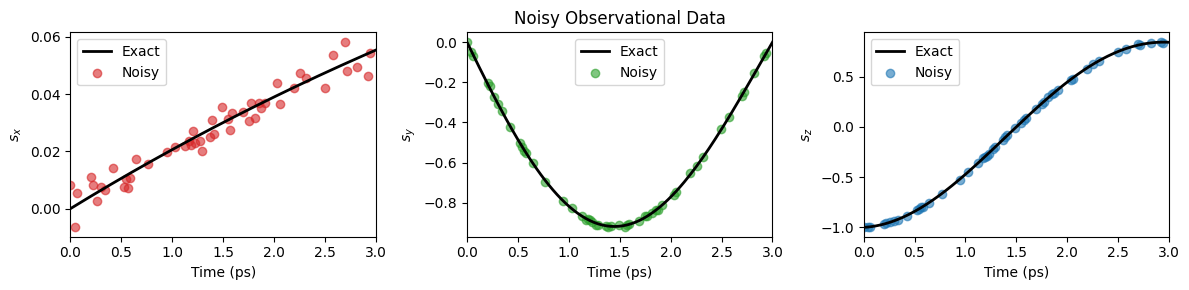

In [ ]:
t_obs, sx_obs, sy_obs, sz_obs = generate_data(sx, sy, sz, D, plot=True)

**Inverse problem 1: Estimation of coupling strength 'A' from noisy data** 

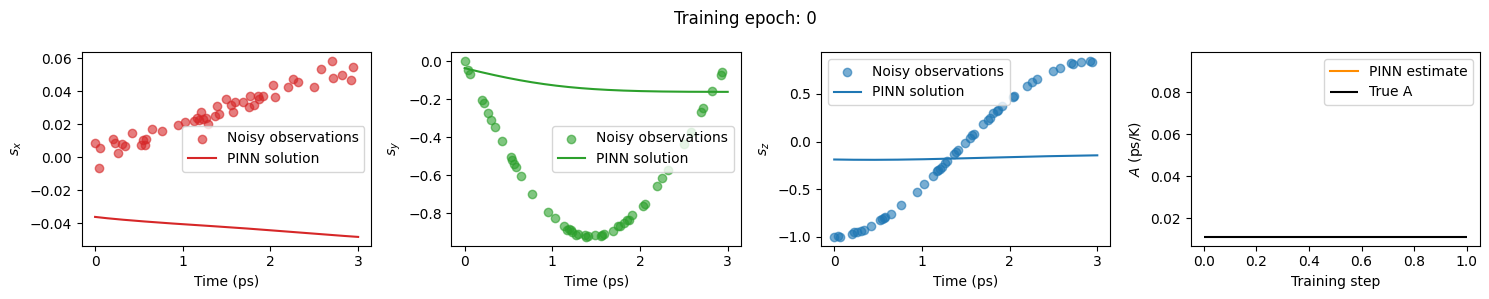

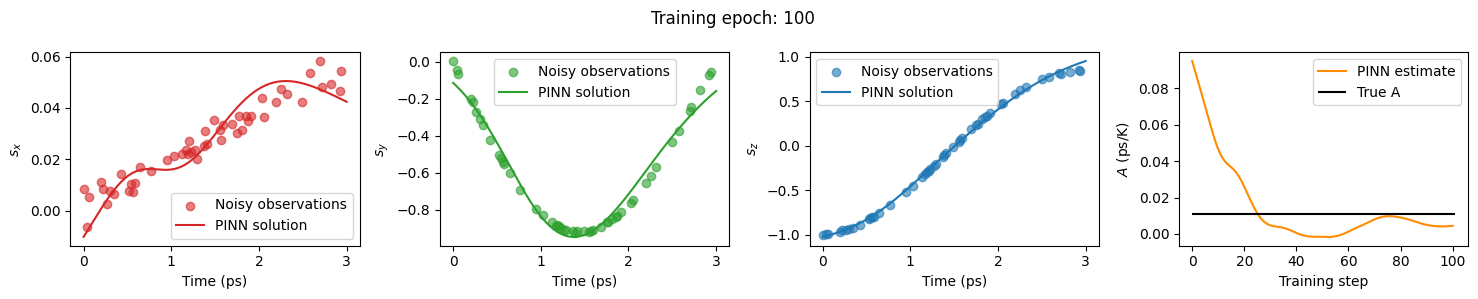

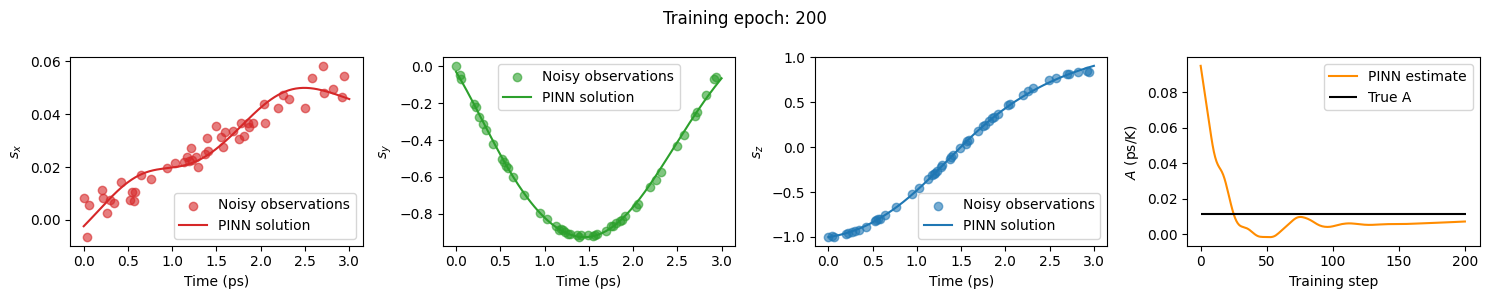

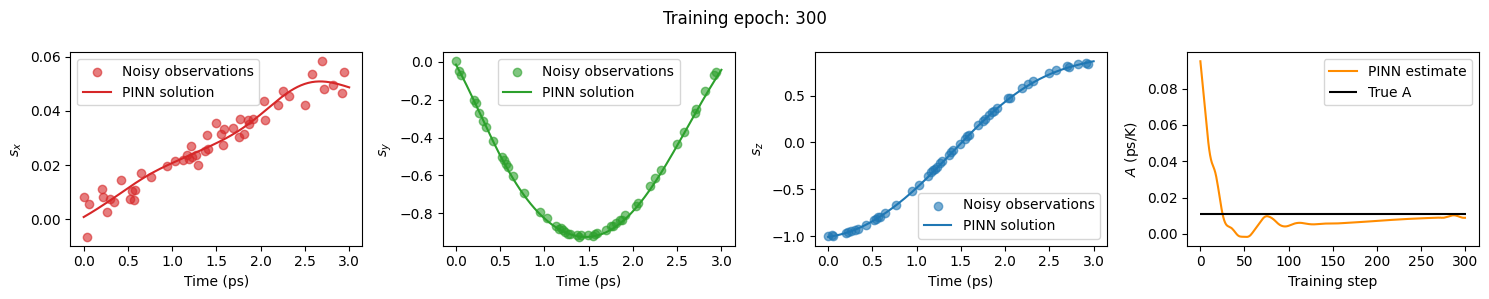

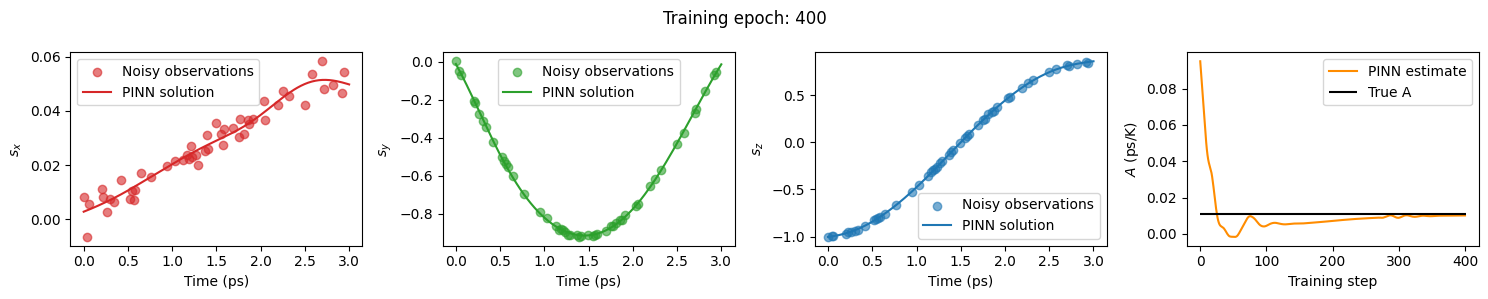

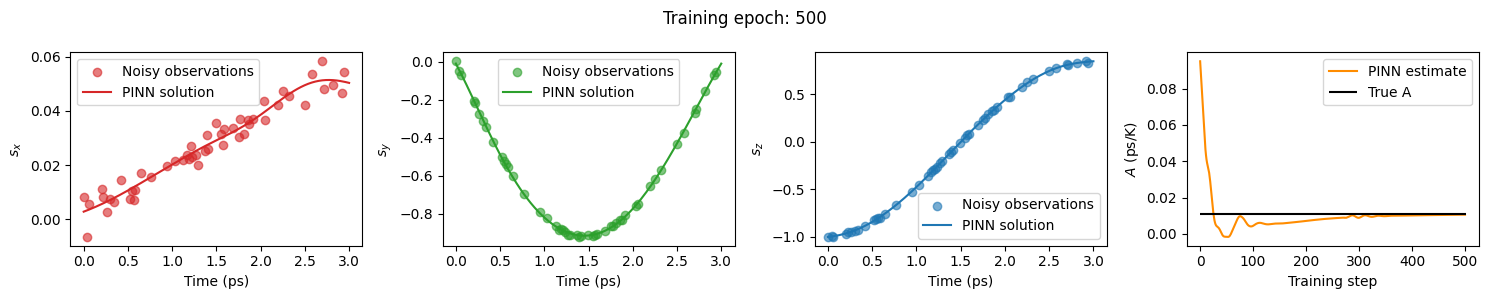

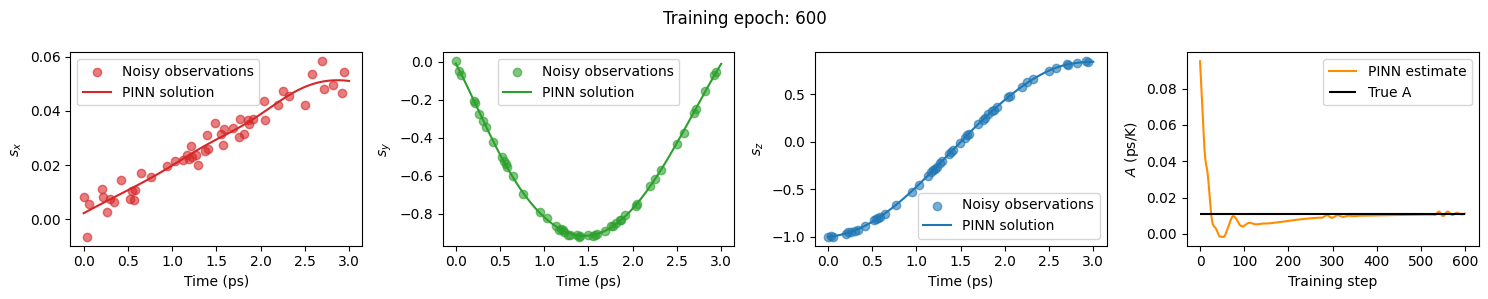

Actual value of coupling strength = 0.01119999960064888 ps/K
Predicted value of coupling strength = 0.011186420917510986 ps/K
Error = 0.12123824656009674 %


In [8]:
t_test = torch.linspace(0,D,150).view(-1,1)

A_pred, model2 = train_inv_pinn_1(A, v_c, T, D, t_obs, sx_obs, sy_obs, sz_obs, 
                                t_test, t_intervals=150, hidden_dim=32, n_layers=4, 
                                epochs=601, lr=5e-3, plot_interval=100)

print(f"Actual value of coupling strength = {A} ps/K")
print(f"Predicted value of coupling strength = {A_pred} ps/K")
print(f"Error = {abs(A - A_pred)*100/A} %")

**Inverse problem 2 : Estimation of cutoff frequency 'v_c' from noisy data**

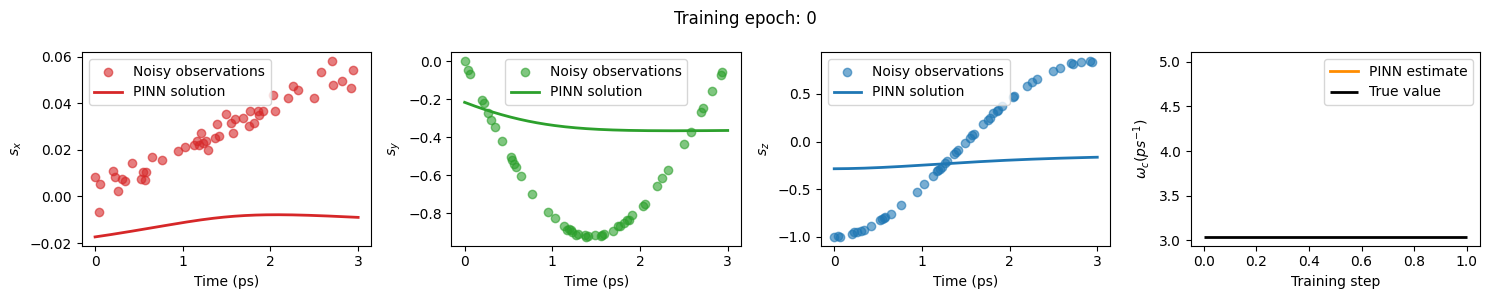

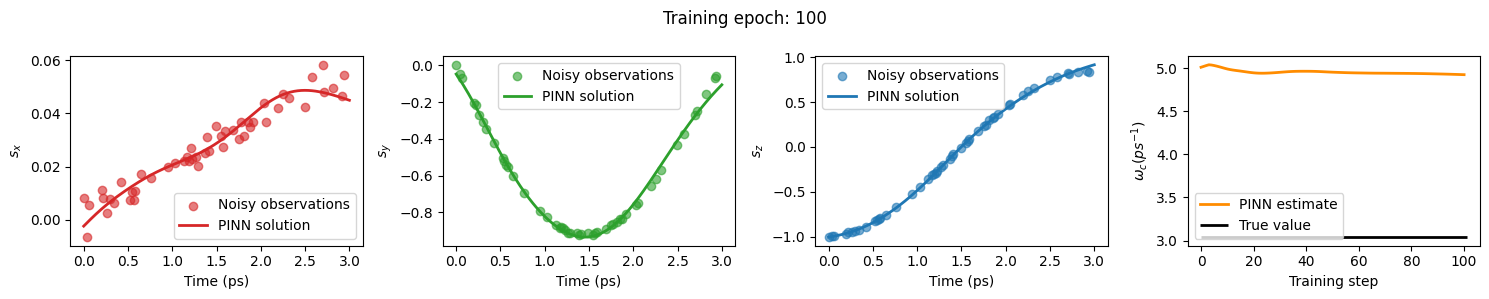

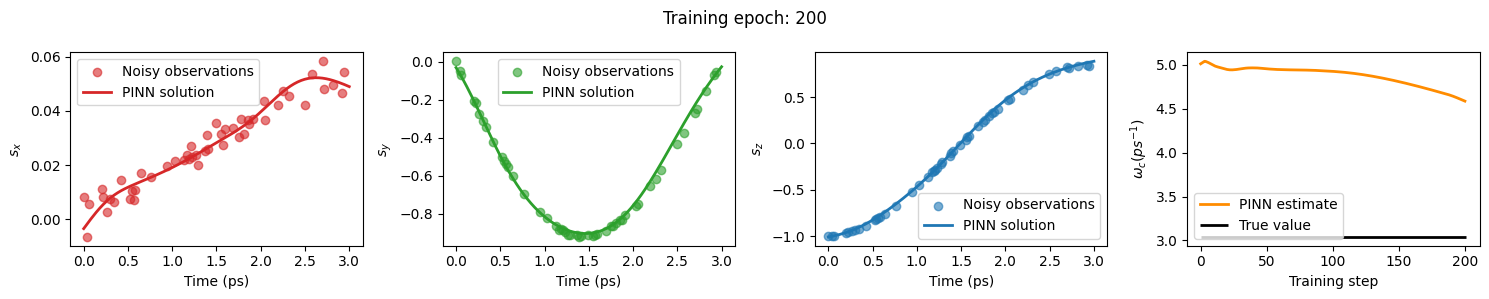

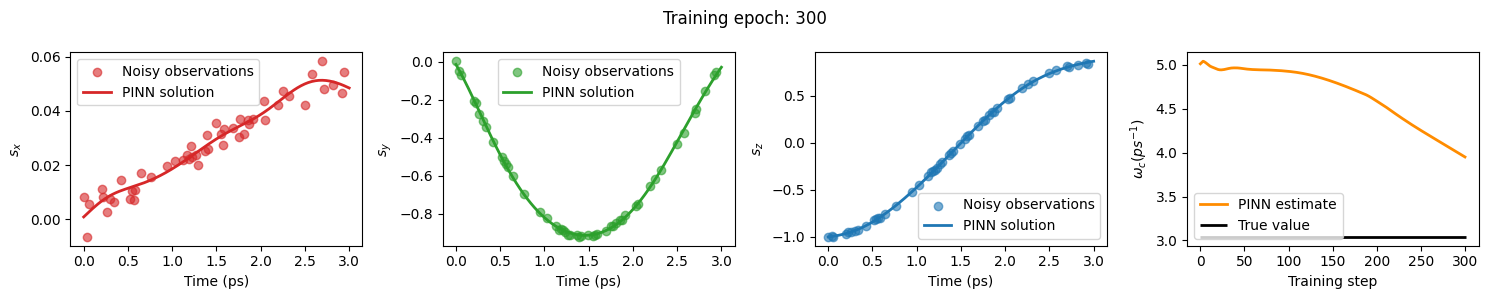

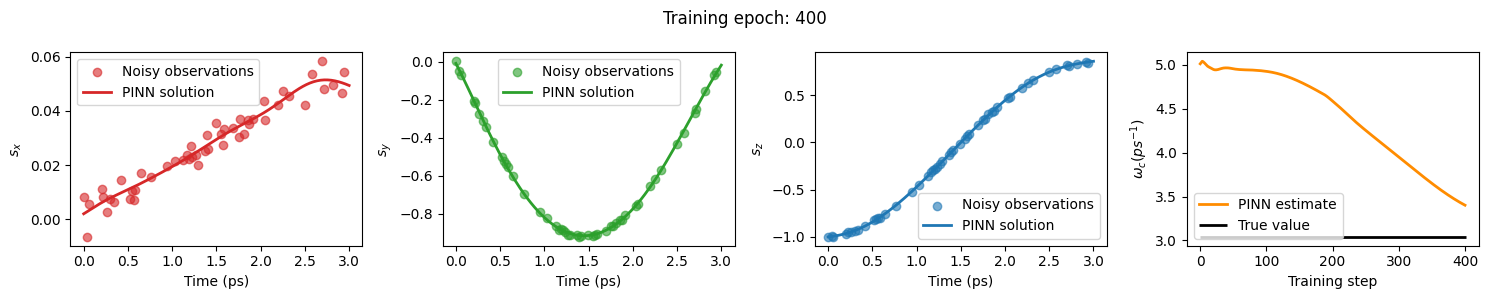

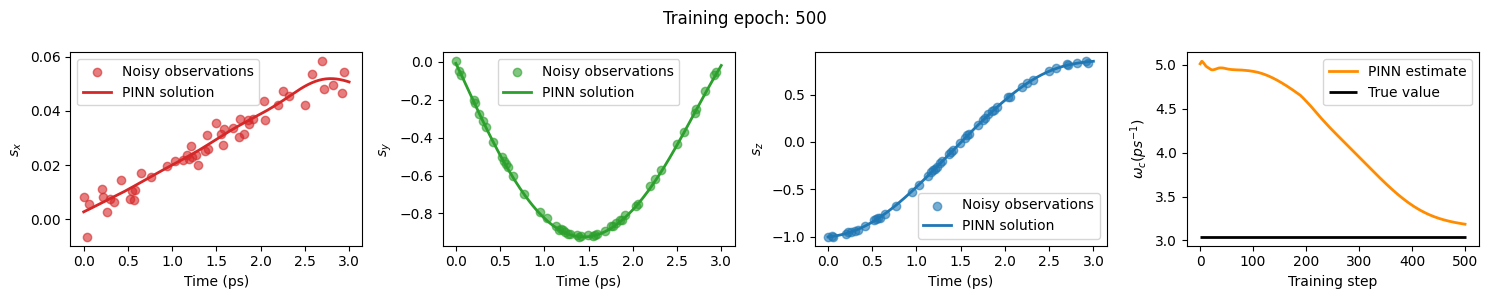

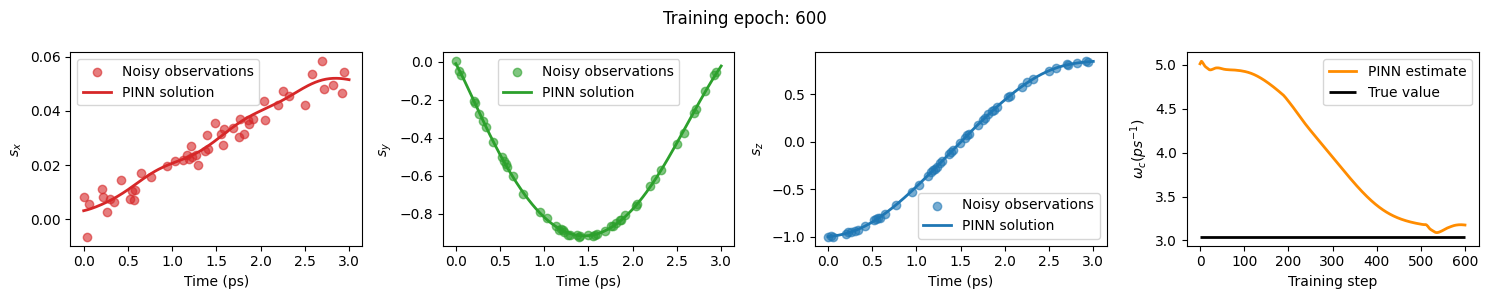

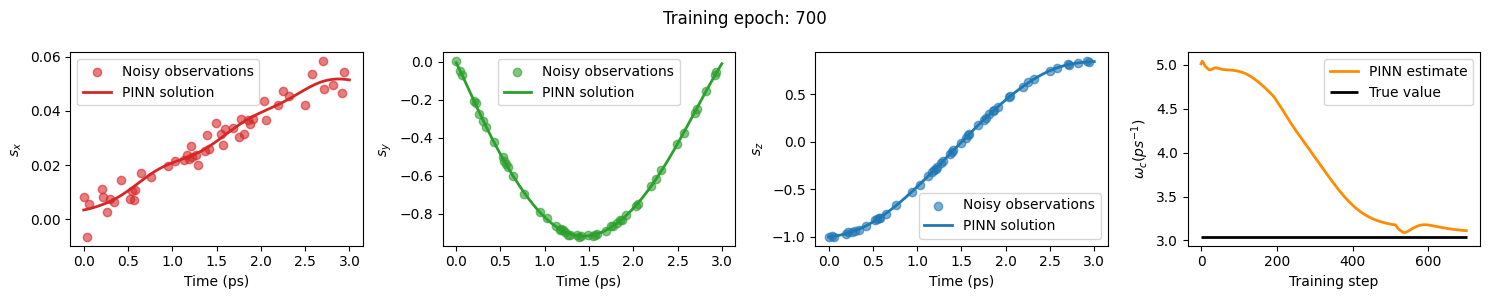

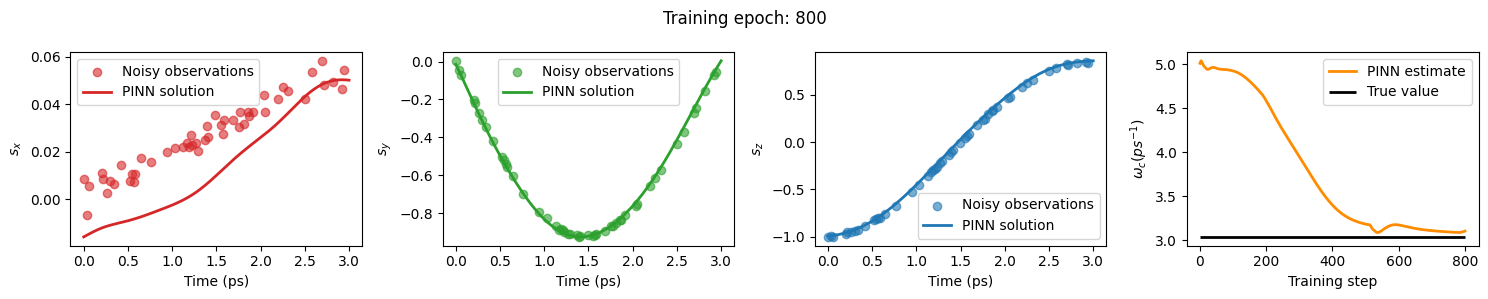

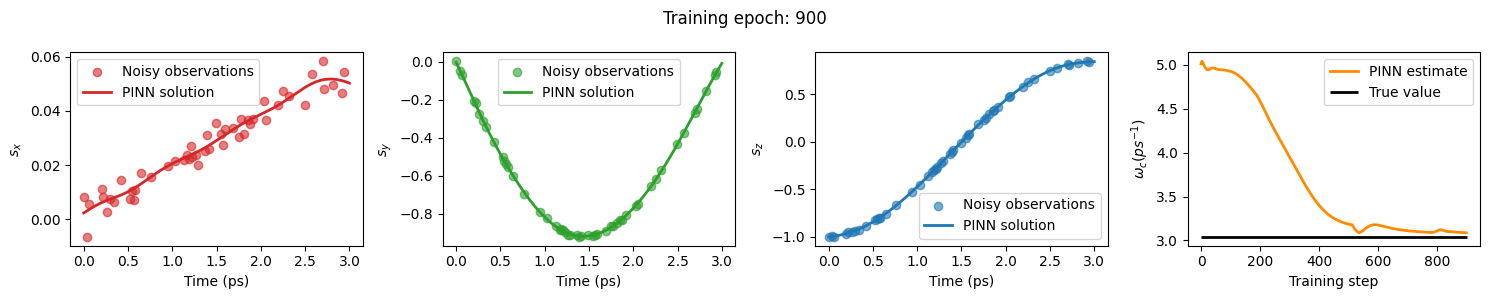

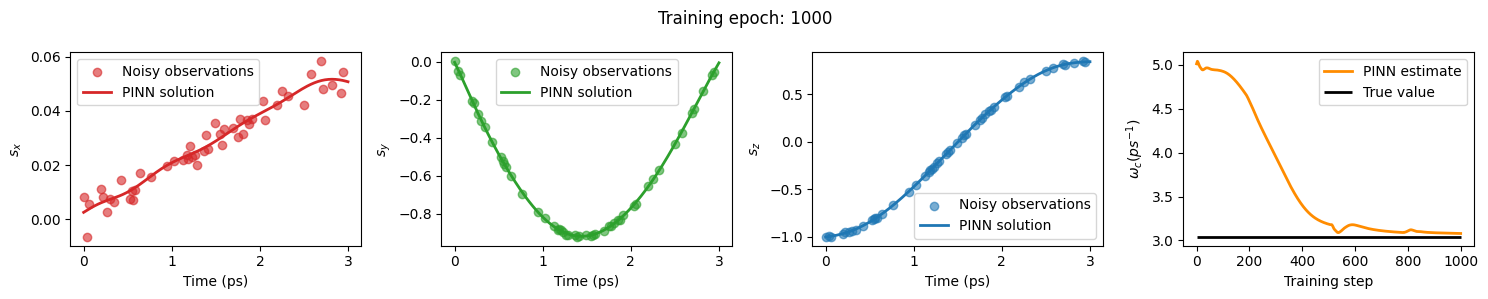

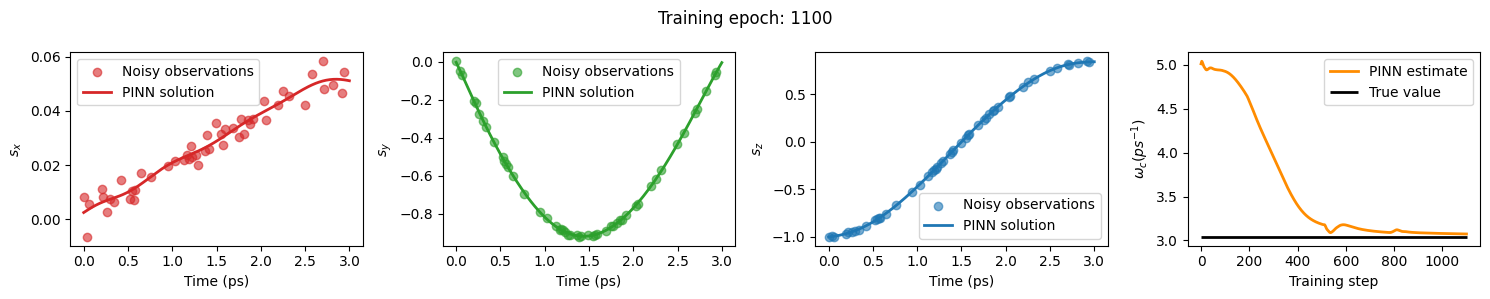

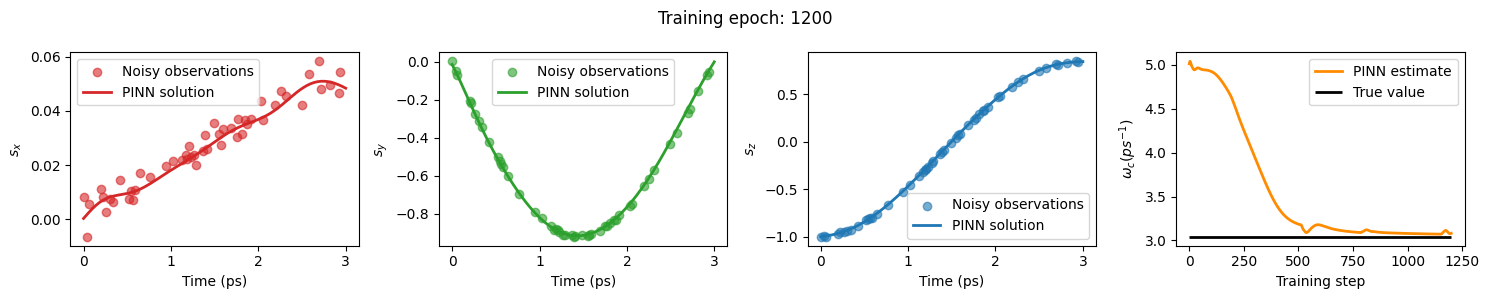

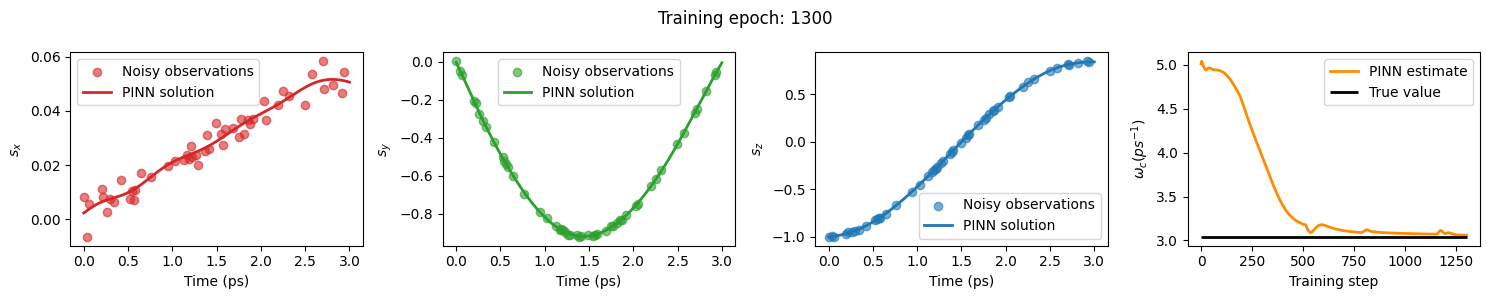

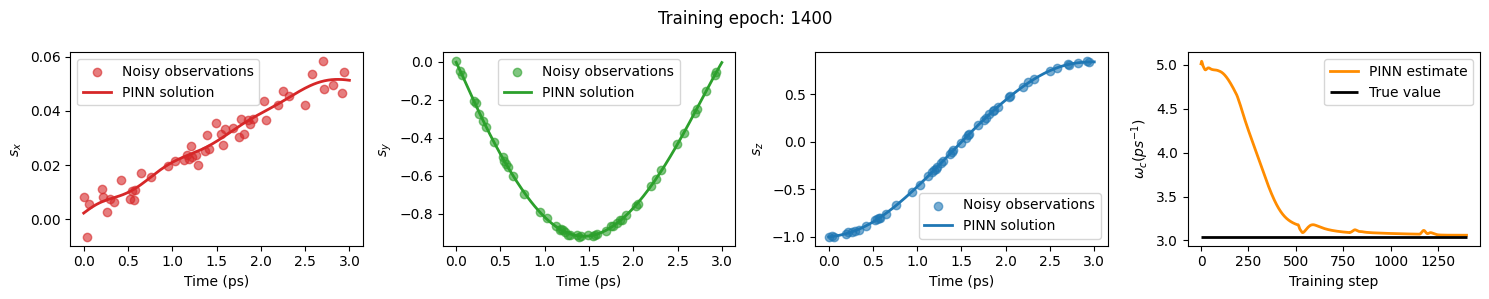

Actual value of cutoff frequency = 3.0399999618530273 1/ps
Predicted value of cutoff frequency = 3.059375524520874 1/ps
Error = 0.6373540163040161 %


In [12]:
alpha = torch.tensor(0.126)
t_test = torch.linspace(0,D,150).view(-1,1)

vc_pred, model2 = train_inv_pinn_2(v_c, alpha, T, D, t_obs, sx_obs, sy_obs, sz_obs, 
                                t_test, t_intervals=150, hidden_dim=32, n_layers=4, 
                                epochs=1401, lambda1=1e2, lr=1e-2, plot_intervals=100)

print(f"Actual value of cutoff frequency = {v_c} 1/ps")
print(f"Predicted value of cutoff frequency = {vc_pred} 1/ps")
print(f"Error = {abs(v_c - vc_pred)*100/v_c} %")